In [56]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [57]:
import torch
import numpy as np
import h5py
import cv2
import PIL
import os, sys, gc
sys.path.append(os.path.abspath("../"))
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
import matplotlib.pyplot as plt
from core.median_filter import apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
def save_png(img,path):
    if type(img) == torch.Tensor:
        img = img.cpu().numpy()
    img = (img-img.min())/(img.max()-img.min())
    img = PIL.Image.fromarray((img*255).astype('uint8'))
    img.save(path, format='png')

In [59]:
folder_name = "./RN2N_output"
os.makedirs(folder_name, exist_ok=True)


In [60]:
def load_img_dict(target_x,target_y,clean_f_num='F64',debug=True):
    possible_f_num = ['F01','F02','F04','F08','F16','F32']
    x_f_num = []
    if target_x == 'F#':
        for f_num in possible_f_num:
            if f_num != target_y:
                x_f_num.append(f_num)
            else :
                break
    else :
        x_f_num = [target_x]
    x_f_num.append(target_y)
    x_f_num.append(clean_f_num)
    print(x_f_num)
    img_dict = {}
    path_list = ["../dataset"
                 ]
    # data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 
    debug = True
    for data_path in path_list:
        print("=====",data_path, "=====")
            
        f_num_list = os.listdir(data_path)
        # print(f_num_list)
        for f_num in f_num_list:
            if f_num[0] != 'F':
                continue
            f_path = os.path.join(data_path,f_num)
            f_number = int(f_num[1:])
            f_num = f"F{f_number:02d}"
            if f_num not in x_f_num:
                print(f_num , " is not in ", x_f_num)
                continue
            img_dict[f_num] = {}
            img_list = sorted(os.listdir(f_path))
            img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
            
            for filename in sorted(img_list):
                
                img_path = os.path.join(f_path,filename)
                image_idx = int(filename.split("_")[1].split(".")[0])
                filename = f"{f_num}_{image_idx:02d}.png"
                if debug is True:
                    print(f_num," & ",filename)
                img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) 
                img = np.expand_dims(img,axis=0) / 255.
                img_dict[f_num][filename] = img
                
                if debug is True:
                    print(f_num,img.shape)
    if debug is True:
        print(img_dict.keys())
        for f_num in img_dict.keys():
            print("   ",img_dict[f_num].keys())
    print("====== load img_dict complete ======")
    return img_dict
                        

In [71]:
clean_f_num = 'F32'
img_dict = load_img_dict('F01','F32',clean_f_num=clean_f_num,debug=True)

['F01', 'F32', 'F32']
===== ../dataset =====
F32  &  F32_01.png
F32 (1, 1710, 2990)
F32  &  F32_11.png
F32 (1, 1710, 2990)
F32  &  F32_12.png
F32 (1, 1710, 2990)
F32  &  F32_02.png
F32 (1, 1710, 2990)
F32  &  F32_21.png
F32 (1, 1710, 2990)
F32  &  F32_03.png
F32 (1, 1710, 2990)
F32  &  F32_31.png
F32 (1, 1710, 2990)
F01  &  F01_01.png
F01 (1, 1710, 2990)
F01  &  F01_11.png
F01 (1, 1710, 2990)
F01  &  F01_12.png
F01 (1, 1710, 2990)
F01  &  F01_02.png
F01 (1, 1710, 2990)
F01  &  F01_21.png
F01 (1, 1710, 2990)
F01  &  F01_03.png
F01 (1, 1710, 2990)
F01  &  F01_31.png
F01 (1, 1710, 2990)
dict_keys(['F32', 'F01'])
    dict_keys(['F32_01.png', 'F32_11.png', 'F32_12.png', 'F32_02.png', 'F32_21.png', 'F32_03.png', 'F32_31.png'])
    dict_keys(['F01_01.png', 'F01_11.png', 'F01_12.png', 'F01_02.png', 'F01_21.png', 'F01_03.png', 'F01_31.png'])
====== load img_dict complete ======


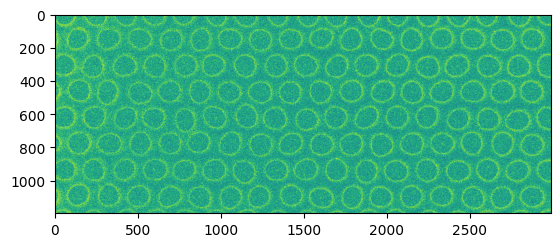

In [62]:
plt.imshow(img_dict['F01']['F01_11.png'][0][256:-256,])

In [63]:

import itertools
def get_fbi_weight(f_num_list = ['F#','F01','F02','F04','F08','F16','F32','F64'],loss = 'MSE_Affine',filter_keyword = ['median']):
    comb = list(itertools.combinations(f_num_list,2))
    total_fbi_weight_list = {}
    for x_f_num,y_f_num in comb:
        fbi_weight_list = glob(f"../weights/230*_FBI_Net*x_as_{x_f_num}*y_as_{y_f_num}*{loss}*")
        for keyword in filter_keyword:
            fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
        total_fbi_weight_list += sorted(list(fbi_weight_list))
        print(x_f_num,y_f_num)
        for fbi_weight in fbi_weight_list:
            print(fbi_weight)
    return total_fbi_weight_list

In [64]:
!ls ../weights/*

../weights/230930_FBI_Net_MSE_Affine_RN2N_F01-F32_Samsung_layers_x17_filters_x64_cropsize_256.w


In [65]:
import glob
debug= False
target_fbi_weight = glob.glob("../weights/*")


In [66]:


def parsing_weight_name(fbi_weight_dir):
    target_f = fbi_weight_dir.split("RN2N_")[1].split("_Samsung")[0]
    target_x,target_y = target_f.split("-")
    info = "_".join(fbi_weight_dir.split("_")[1:]).split("_Grayscale")[0]
    print(info)
    arch, loss_func = "_".join(info.split("_")[:2]), ("_".join(info.split("_")[2:]).split("_RN2N_")[0])
    try: 
        add_info = fbi_weight_dir.split("cropsize_256_")[1].split(".w")[0]
    except :
        add_info = ""
    return target_x,target_y, arch, loss_func, add_info


In [67]:
for weight in target_fbi_weight:
    print(parsing_weight_name(weight))

FBI_Net_MSE_Affine_RN2N_F01-F32_Samsung_layers_x17_filters_x64_cropsize_256.w
('F01', 'F32', 'FBI_Net', 'MSE_Affine', '')


In [68]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'NAFNet_light'#'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200

In [87]:
from re import T
from core.utils import get_PSNR,get_SSIM

metric = {}
metric['median_filter'] = {
    'PSNR' : [],
    'SSIM' : []
}
metric['raw'] = {
        'PSNR' : {},
        'SSIM' : {}
    }
os.makedirs(f"{folder_name}/median_filter",exist_ok=True)
for weight_idx,fbi_weight_dir in enumerate(target_fbi_weight):

    target_x,target_y, arch, loss_func,add_info = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}_{arch}"
    if loss_func != 'MSE_Affine':
        key += f"_{loss_func}"
    if add_info != "":
        key += f"_{add_info}"
    model_img_path = f"{folder_name}/{key}"
    os.makedirs(model_img_path,exist_ok=True)
    args.loss_function = loss_func
    args.model_type = arch
    if args.loss_function == 'EMSE_Affine':
        args.pge_weight_dir = "../weights/230914_PGE_Net_Noise_est_Grayscale_N2N_F01-F01_Samsung_Noise_est_cropsize_256_vst_MSE.w"
    else :
        args.pge_weight_dir = None
    print(f"========= {key}  & {loss_func }=========")
    
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    if target_x == 'F#':
        f_num = 'F01'
    else :
        f_num = target_x
        
    metric[key] = {
            'PSNR' : {},
            'SSIM' : {}
        }
    print(clean_f_num)
    img_dict = load_img_dict(f_num,target_y,clean_f_num,debug=False)
    for f_num in [target_x]:
            
                # print(f"Since F#, f_num : {f_num} Start")
        print(f"Denoising,f_num : {f_num} Start")
        for idx,(filename, img) in enumerate(img_dict[f_num].items()):
            img = np.expand_dims(img, axis=0) # 1,1536x3074
            F32_img = img_dict['F32'][filename.replace(f_num,'F32')][0]
            clean_img = img_dict[clean_f_num][filename.replace(f_num,clean_f_num)][0]
            print(filename,f_num,idx,img.shape)
            denoised_img = model.eval(img)[0][0]
            img = img[0][0]
            metric[key]['PSNR'][filename.split(".")[0]] = get_PSNR(clean_img[256:-256],denoised_img[256:-256])
            metric[key]['SSIM'][filename.split(".")[0]] = get_SSIM(clean_img[256:-256],denoised_img[256:-256])
            
            if os.path.exists(f"{model_img_path}/{filename}") is False:
                print("imwrite : ",f"{model_img_path}/{filename}")
                if type(denoised_img) == torch.Tensor:
                    denoised_img = denoised_img.cpu().detach().numpy()
                print(denoised_img.shape)
                cv2.imwrite(f"{model_img_path}/{filename}",denoised_img*255)
            
            if weight_idx == 0:
                metric['raw']['PSNR'][filename.split(".")[0]] = get_PSNR(clean_img[256:-256],img[256:-256])
                metric['raw']['SSIM'][filename.split(".")[0]] = get_SSIM(clean_img[256:-256],img[256:-256])
            
                medianfilterd_img = apply_median_filter_gpu_simple(img)[0][0]
                median_psnr, median_ssim =  get_PSNR(clean_img[256:-256],medianfilterd_img[256:-256]), get_SSIM(clean_img[256:-256],medianfilterd_img[256:-256])
                metric['median_filter']['PSNR'].append(median_psnr)
                metric['median_filter']['SSIM'].append(median_ssim)
                cv2.imwrite(f"median_filter/{filename}",medianfilterd_img*255)
                
                
        print(f"Denoising, f_num : {f_num} End")
    del model
    gc.collect()


FBI_Net_MSE_Affine_RN2N_F01-F32_Samsung_layers_x17_filters_x64_cropsize_256.w
========= F01-F32_FBI_Net  & MSE_Affine=========
F32
['F01', 'F32', 'F32']
===== ../dataset =====
F32  &  F32_01.png
F32 (1, 1710, 2990)
F32  &  F32_11.png
F32 (1, 1710, 2990)
F32  &  F32_12.png
F32 (1, 1710, 2990)
F32  &  F32_02.png
F32 (1, 1710, 2990)
F32  &  F32_21.png
F32 (1, 1710, 2990)
F32  &  F32_03.png
F32 (1, 1710, 2990)
F32  &  F32_31.png
F32 (1, 1710, 2990)
F01  &  F01_01.png
F01 (1, 1710, 2990)
F01  &  F01_11.png
F01 (1, 1710, 2990)
F01  &  F01_12.png
F01 (1, 1710, 2990)
F01  &  F01_02.png
F01 (1, 1710, 2990)
F01  &  F01_21.png
F01 (1, 1710, 2990)
F01  &  F01_03.png
F01 (1, 1710, 2990)
F01  &  F01_31.png
F01 (1, 1710, 2990)
dict_keys(['F32', 'F01'])
    dict_keys(['F32_01.png', 'F32_11.png', 'F32_12.png', 'F32_02.png', 'F32_21.png', 'F32_03.png', 'F32_31.png'])
    dict_keys(['F01_01.png', 'F01_11.png', 'F01_12.png', 'F01_02.png', 'F01_21.png', 'F01_03.png', 'F01_31.png'])
====== load img_dict com

In [83]:
refined_metric = {}
for key in metric.keys():
    # print(key)
    refined_metric[key] = {}
    for sub_key in metric[key].keys():     
        # print(key,sub_key)
        if type(metric[key][sub_key]) == dict:
            metric[key][sub_key] = list(metric[key][sub_key].values())
        refined_metric[key][f'{sub_key}'] = np.mean(metric[key][sub_key])
        

import pandas as pd
refined_metric = pd.DataFrame(refined_metric)
refined_metric

,median_filter,raw,F01-F32_FBI_Net
PSNR,15.193202,10.853934,10.852271
SSIM,0.151958,0.024024,0.024014


In [84]:
refined_metric.T.to_csv(f"{folder_name}/metric.csv")